# Stage 5 (2.3 catboost_2_stage_model)

# Импортируем библиотеки

In [1]:
import warnings


# ----------------
# Data processing
# ----------------
import dill

import numpy as np
import polars as pl

from tqdm.auto import tqdm


# ---------------------
# RecSys models imports
# ---------------------

from catboost import CatBoostRanker, Pool


# --------------
# Plotting libs
# --------------
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import shap


# -------------------
# Metrics Evaluation
# -------------------
from metrics import RecommenderMetrics


# -------------------
# Utils
# -------------------
from utils import get_catboost_group_id, add_score_and_rank


warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

RANDOM_STATE = 42

# Импортируем пути

In [2]:
data_path = "../data/closed/"
models_path = "../data/models/"
candidates_data_path = models_path + "candidates_data/"


# Модель второго уровня (ранкер)

## Ranker Data

In [3]:
ranker_train = pl.scan_parquet(data_path + "ranker_train.parquet")
ranker_val = pl.scan_parquet(data_path + "ranker_val.parquet")
# ranker_test = pl.scan_parquet(data_path + "ranker_test.parquet")

### Выбираем колонки на которых будет обучаться ранкер

In [4]:
ranker_train.schema

Schema([('user_id', Int64),
        ('item_id', Int64),
        ('ui_inter', UInt32),
        ('cos_score', Float32),
        ('cos_rank', Int64),
        ('bm25_score', Float32),
        ('bm25_rank', Int64),
        ('tfidf_score', Float32),
        ('tfidf_rank', Int64),
        ('lfm_score', Float32),
        ('lfm_rank', Int64),
        ('user_hist', UInt32),
        ('user_avg_pop', Float64),
        ('user_last_pop', Float64),
        ('title_len', Float64),
        ('descr_len', Float64),
        ('title_word_len', Float64),
        ('descr_word_len', Float64),
        ('txt_emb_pca_0', Float32),
        ('txt_emb_pca_1', Float32),
        ('txt_emb_pca_2', Float32),
        ('txt_emb_pca_3', Float32),
        ('txt_emb_pca_4', Float32),
        ('txt_emb_pca_5', Float32),
        ('txt_emb_pca_6', Float32),
        ('txt_emb_pca_7', Float32),
        ('txt_emb_pca_8', Float32),
        ('txt_emb_pca_9', Float32),
        ('brand', Int64),
        ('color', Int64),
        ('cl

In [5]:
# Убираем таргет, айдишники
# и данные, на которых обучались модели первого уровня
FEATURES = [
    "cos_score",
    "cos_rank",
    "bm25_score",
    "bm25_rank",
    "tfidf_score",
    "tfidf_rank",
    "lfm_score",
    "lfm_rank",
    #---------------
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    #---------------
    "item_pop",
    "item_avg_hist",
    #---------------
    "title_len",
    "descr_len",
    "title_word_len",
    "descr_word_len",
    "txt_emb_pca_0",
    "txt_emb_pca_1",
    "txt_emb_pca_2",
    "txt_emb_pca_3",
    "txt_emb_pca_4",
    "txt_emb_pca_5",
    "txt_emb_pca_6",
    "txt_emb_pca_7",
    "txt_emb_pca_8",
    "txt_emb_pca_9",
    #---------------
    "img_emb_pca_0",
    "img_emb_pca_1",
    "img_emb_pca_2",
    "img_emb_pca_3",
    "img_emb_pca_4",
    "img_emb_pca_5",
    "img_emb_pca_6",
    "img_emb_pca_7",
    "img_emb_pca_8",
    "img_emb_pca_9",
    #---------------
    "brand",
    "color",
    "closure",
    "country",
    "cut",
    "height",
    "length",
    "material",
    "model",
    "neckline",
    "pattern",
    "pocket",
    "purpose",
    "sleeve",
]
# Из cols следующие фитчи численные
NUMERICAL_FEATURES = [
    "cos_score",
    "cos_rank",
    "bm25_score",
    "bm25_rank",
    "tfidf_score",
    "tfidf_rank",
    "lfm_score",
    "lfm_rank",
    #---------------
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    #---------------
    "item_pop",
    "item_avg_hist",
    #---------------
    "title_len",
    "descr_len",
    "title_word_len",
    "descr_word_len",
    "txt_emb_pca_0",
    "txt_emb_pca_1",
    "txt_emb_pca_2",
    "txt_emb_pca_3",
    "txt_emb_pca_4",
    "txt_emb_pca_5",
    "txt_emb_pca_6",
    "txt_emb_pca_7",
    "txt_emb_pca_8",
    "txt_emb_pca_9",
    #---------------
    "img_emb_pca_0",
    "img_emb_pca_1",
    "img_emb_pca_2",
    "img_emb_pca_3",
    "img_emb_pca_4",
    "img_emb_pca_5",
    "img_emb_pca_6",
    "img_emb_pca_7",
    "img_emb_pca_8",
    "img_emb_pca_9",
]
# Из cols следующие фитчи категориальные
CATEGORIAL_FEATURES = [
    "brand",
    "color",
    "closure",
    "country",
    "cut",
    "height",
    "length",
    "material",
    "model",
    "neckline",
    "pattern",
    "pocket",
    "purpose",
    "sleeve",
]

## CatBoost Data Aggregation


In [6]:
ranker_train = ranker_train.sort(by="user_id")
ranker_val = ranker_val.sort(by="user_id")

## CatBoost Ranker


In [7]:
train_pool = Pool(
    data=ranker_train.select(FEATURES).collect().to_pandas(),
    label=ranker_train.select("target").collect().to_pandas(),
    group_id=get_catboost_group_id(ranker_train),
    cat_features=CATEGORIAL_FEATURES,
)

val_pool = Pool(
    data=ranker_val.select(FEATURES).collect().to_pandas(),
    label=ranker_val.select("target").collect().to_pandas(),
    group_id=get_catboost_group_id(ranker_val),
    cat_features=CATEGORIAL_FEATURES,
)


In [9]:
early_stopping_rounds = 32  # число итераций, в течение которых нет улучшения метрик

params = {
    "objective": "YetiRank",  # catboost аналог lambdarank, оптимизирующий ndcg и map
    "custom_metric": [
        "NDCG:top=10",
        "NDCG:top=15",
        "NDCG:top=5",
        "NDCG:top=3",
    ],
    "iterations": 750,
    "max_depth": 8,
    "num_leaves": 40,
    "min_child_samples": 124,
    "learning_rate": 0.195,
    "reg_lambda": 1.5,
    "subsample": 0.9,
    "early_stopping_rounds": early_stopping_rounds,
    "verbose": early_stopping_rounds // 2,  # период вывода метрик
    "random_state": RANDOM_STATE,
    "bootstrap_type": "Bernoulli",  # Change bootstrap_type
    "grow_policy": "Lossguide",
    "task_type": "GPU",
}

cb_ranker_model = CatBoostRanker(**params)

cb_ranker_model.fit(train_pool, eval_set=val_pool)

Groupwise loss function. OneHotMaxSize set to 10


Default metric period is 5 because NDCG is/are not implemented for GPU
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=15;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=3;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.9188750	best: 0.9188750 (0)	total: 429ms	remaining: 5m 21s
16:	total: 5.13s	remaining: 3m 41s
32:	total: 9.83s	remaining: 3m 33s
48:	total: 14.5s	remaining: 3m 27s
64:	total: 19.2s	remaining: 3m 21s
80:	test: 0.9230062	best: 0.9230062 (80)	total: 23.9s	remaining: 3m 17s
96:	total: 28.6s	remaining: 3m 12s
112:	total: 33.2s	remaining: 3m 7s
128:	total: 37.9s	remaining: 3m 2s
144:	total: 42.5s	remaining: 2m 57s
160:	test: 0.9245033	best: 0.9245033 (160)	total: 47.2s	remaining: 2m 52s
176:	total: 51.9s	remaining: 2m 47s
192:	total: 56.5s	remaining: 2m 43s
208:	total: 1m 1s	remaining: 2m 38s
224:	total: 1m 5s	remaining: 2m 33s
240:	test: 0.9256051	best: 0.9256051 (240)	total: 1m 10s	remaining: 2m 28s
256:	total: 1m 14s	remaining: 2m 23s
272:	total: 1m 19s	remaining: 2m 18s
288:	total: 1m 23s	remaining: 2m 13s
304:	total: 1m 28s	remaining: 2m 9s
320:	test: 0.9264764	best: 0.9264764 (320)	total: 1m 33s	remaining: 2m 4s
336:	total: 1m 37s	remaining: 1m 59s
352:	total: 1m 41s	remaini

In [10]:
from catboost import MetricVisualizer

w = MetricVisualizer("catboost_info/")
w.start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [11]:
# Save CB model
cb_ranker_model.save_model(models_path + "CB_ranker_model_best_5.cbm")

## TEST RANKER

In [13]:
# Загрузим listwise_model
cb_ranker_model = CatBoostRanker().load_model(models_path + "CB_ranker_model_best_4.cbm")

In [14]:
ranker_test = pl.scan_parquet(data_path + "ranker_test.parquet")

In [15]:
ids = np.unique(get_catboost_group_id(ranker_test))[:100]

In [16]:
test_shap_pool = Pool(
    data=ranker_test.filter(pl.col("user_id").is_in(ids))
    .select(FEATURES)
    .collect()
    .to_pandas(),
    group_id=get_catboost_group_id(ranker_test.filter(pl.col("user_id").is_in(ids))),
    cat_features=CATEGORIAL_FEATURES,
)

### SHAP plots

In [17]:
explainer = shap.Explainer(cb_ranker_model)
shap_values = explainer(test_shap_pool)

In [18]:
# Some magic for proper catboost.Pool interpretation inside shap
shap_values.data = (
    ranker_test.filter(pl.col("user_id").is_in(ids))
    .select(FEATURES)
    .collect()
    .to_pandas()
)
shap_values.feature_names = FEATURES

#### WaterFall plot

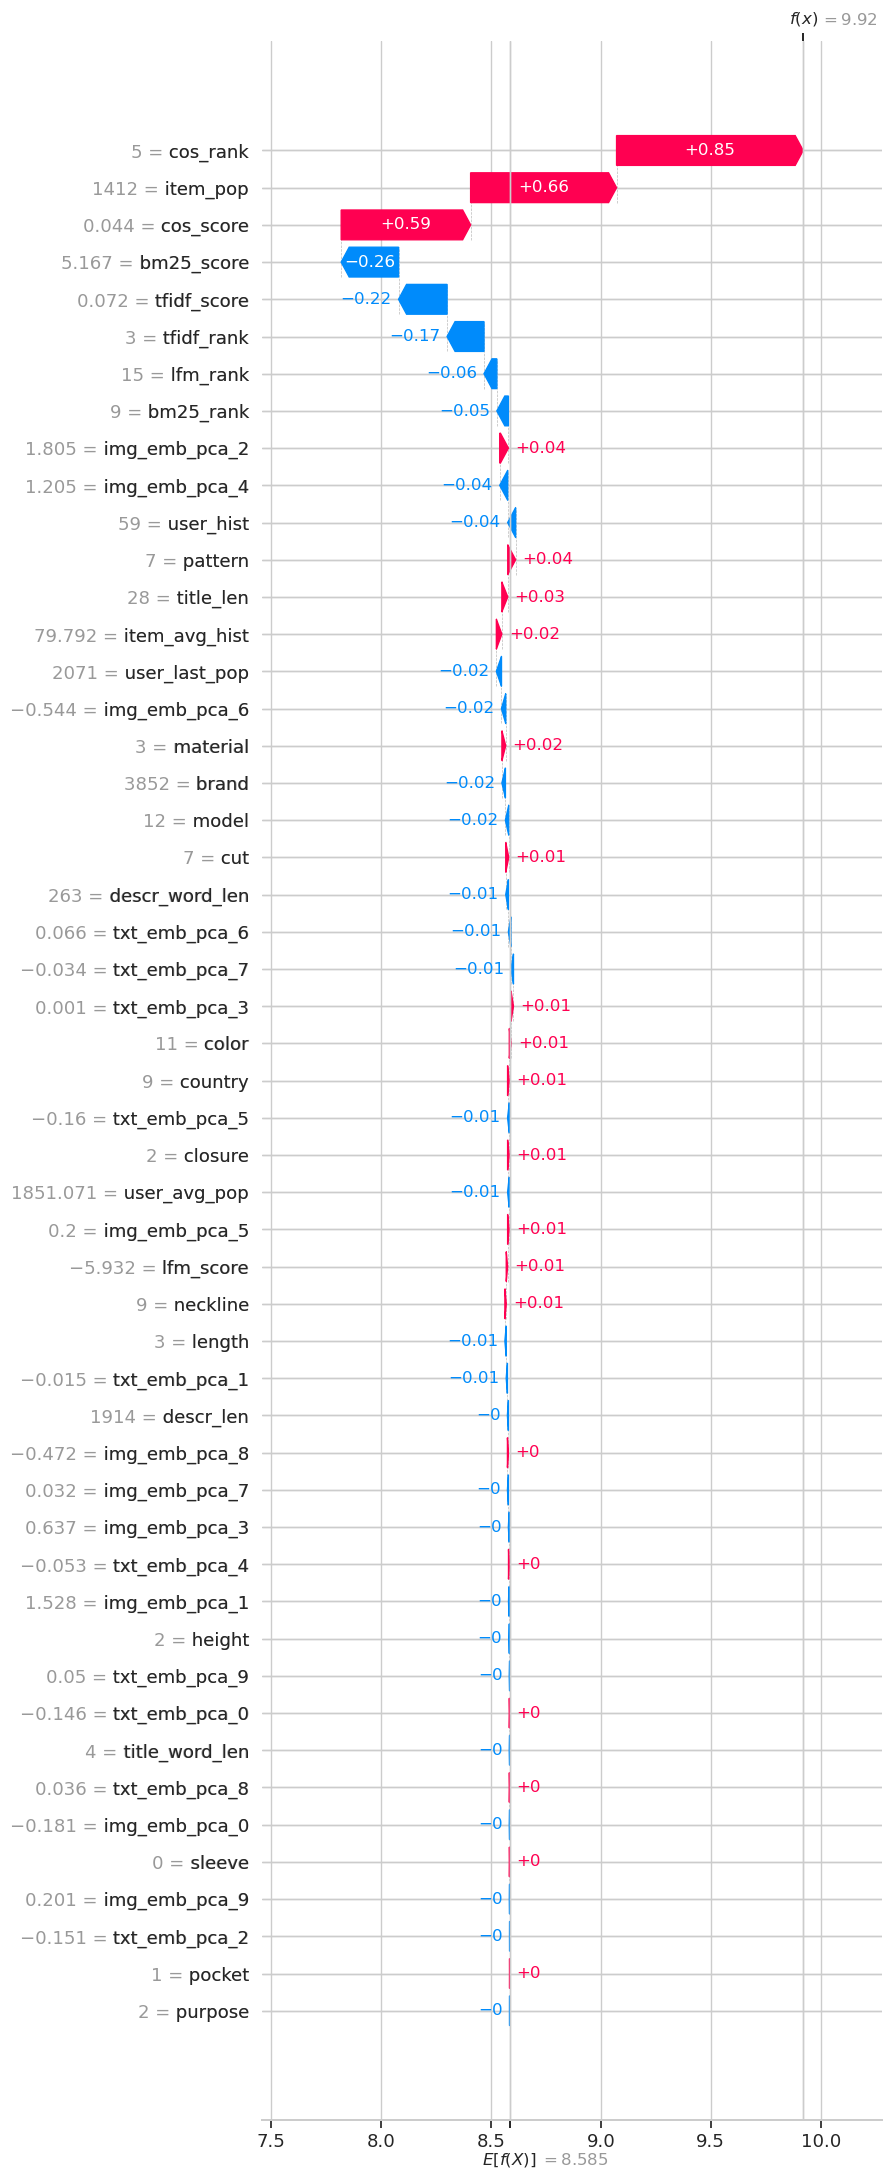

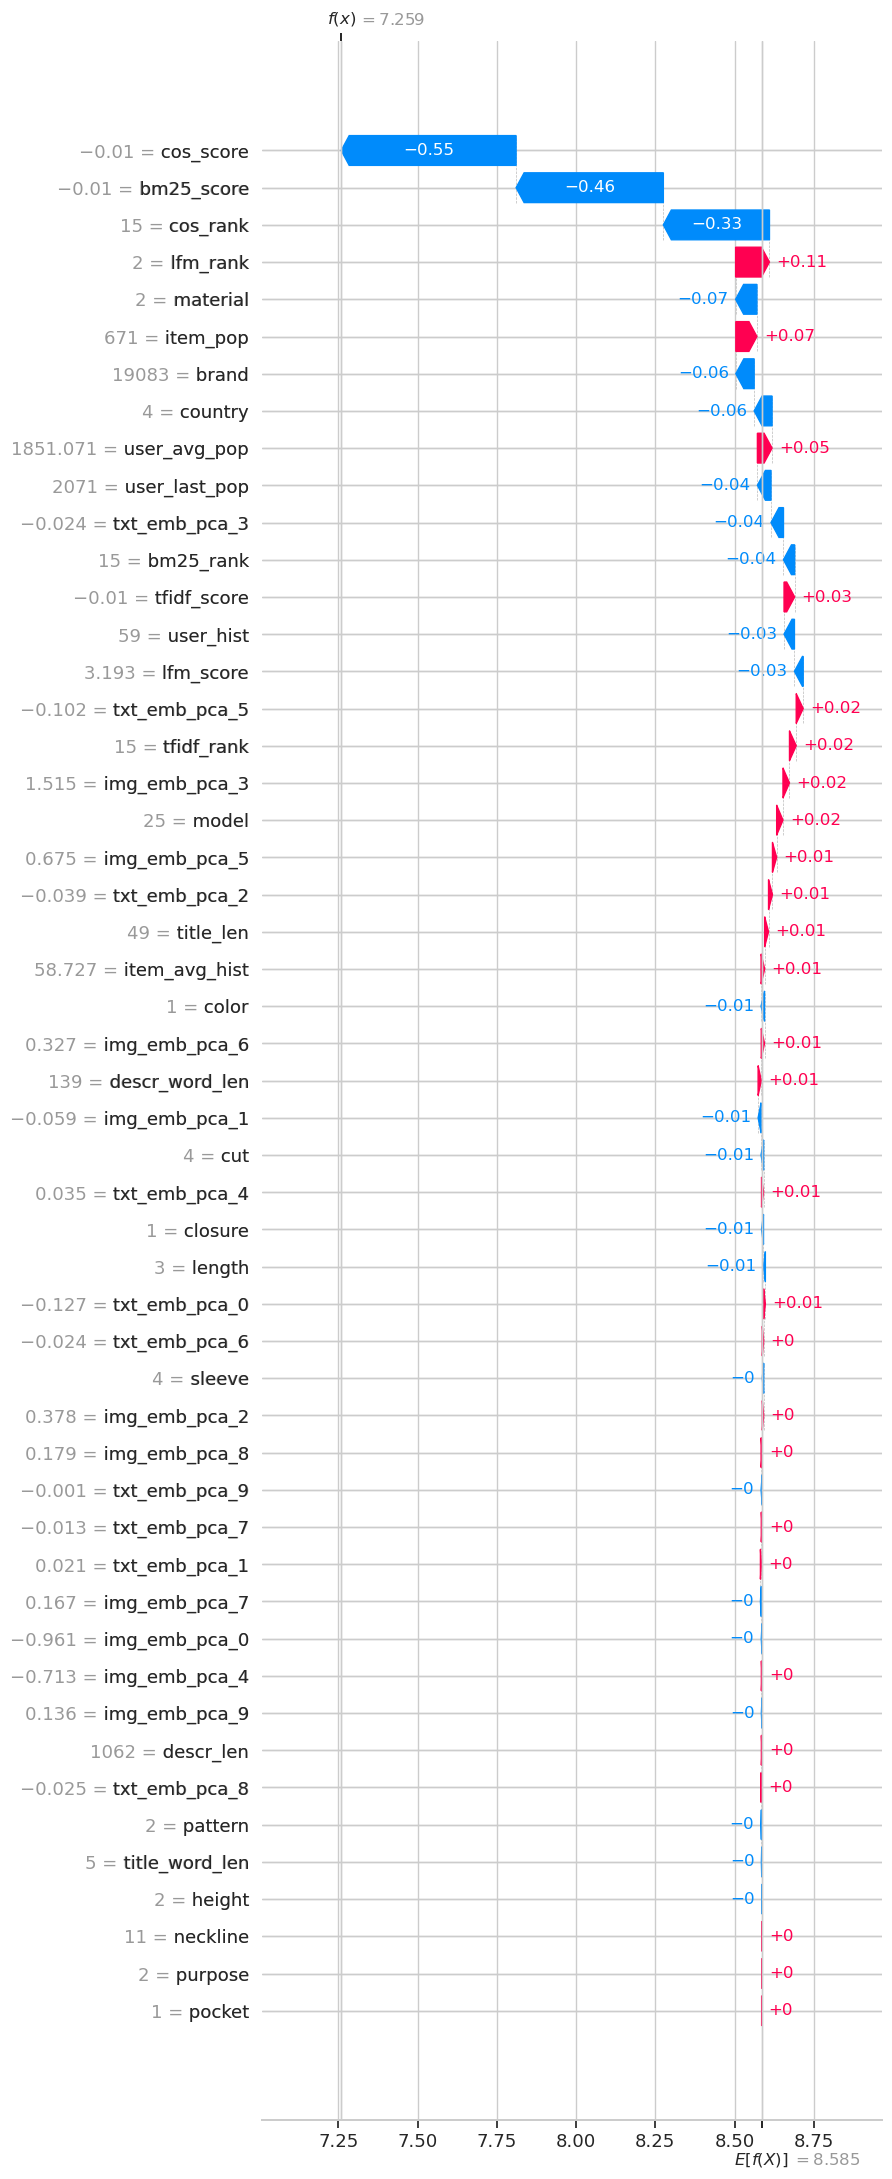

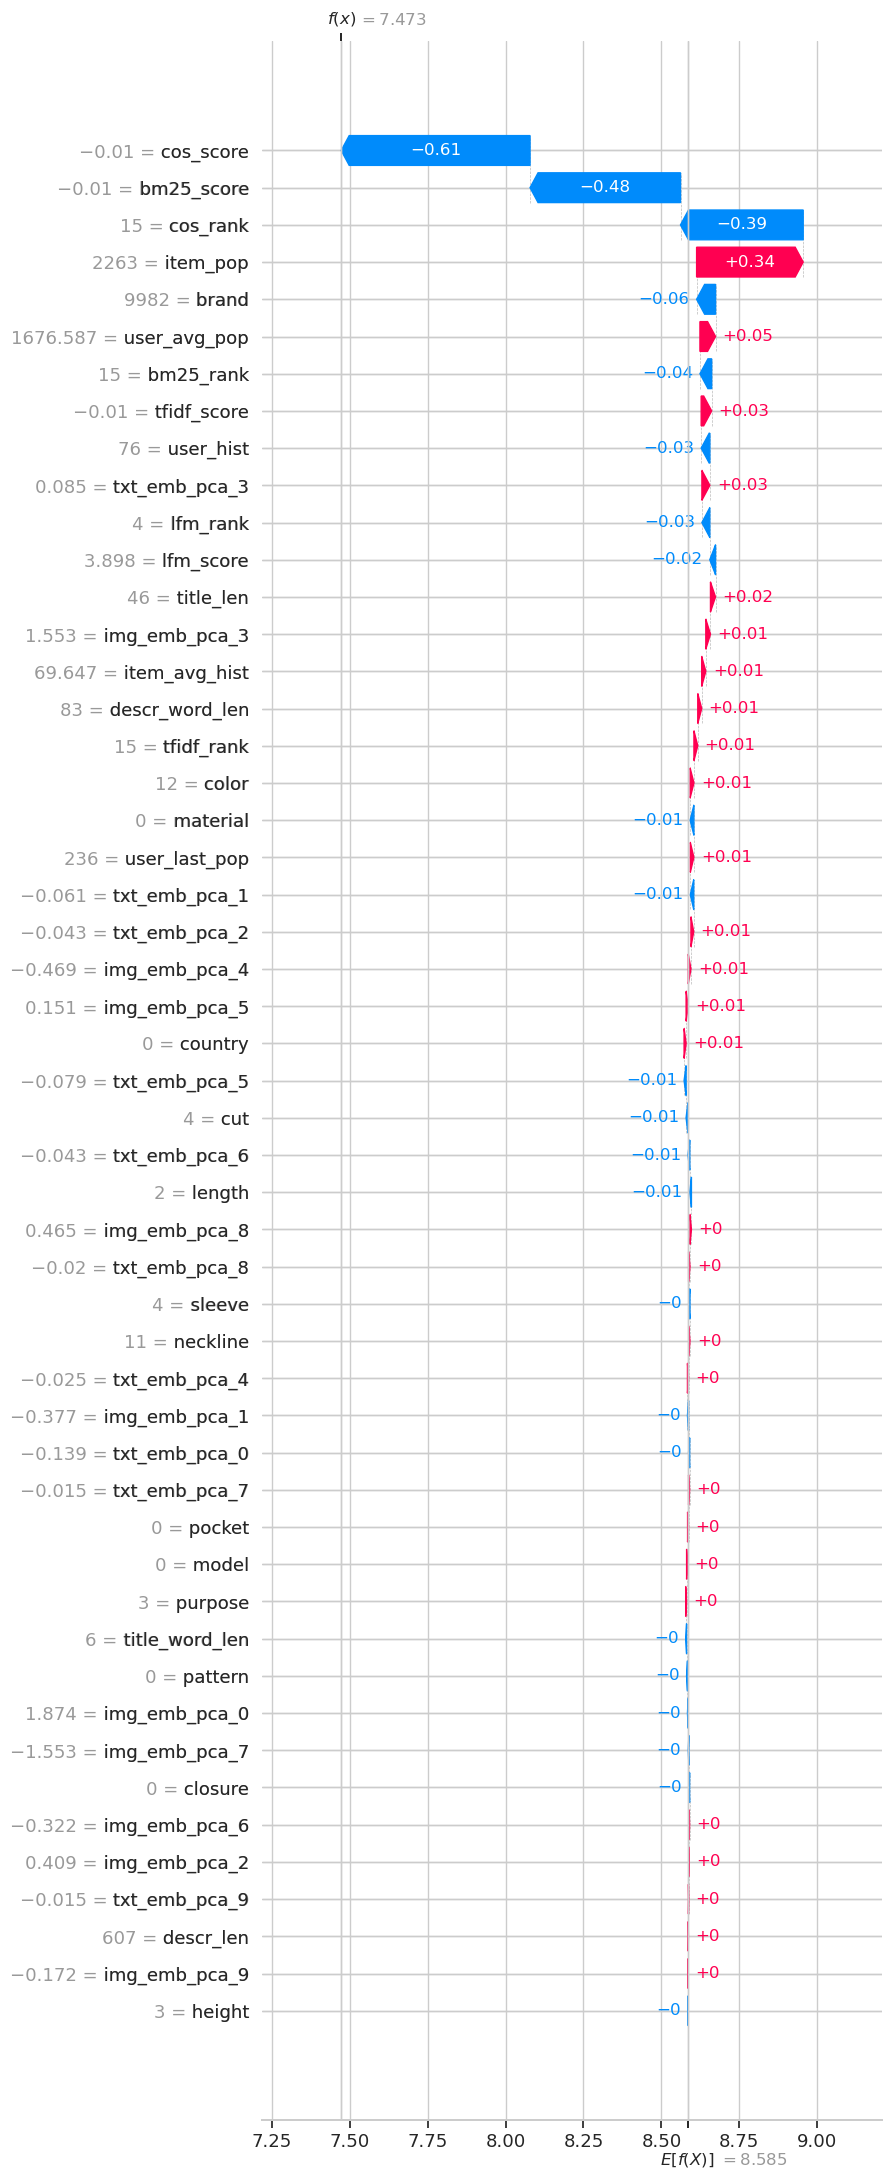

In [19]:
shap.plots.waterfall(shap_values[0], max_display=len(FEATURES))
shap.plots.waterfall(shap_values[1], max_display=len(FEATURES))
shap.plots.waterfall(shap_values[200], max_display=len(FEATURES))

#### beeswarm plot

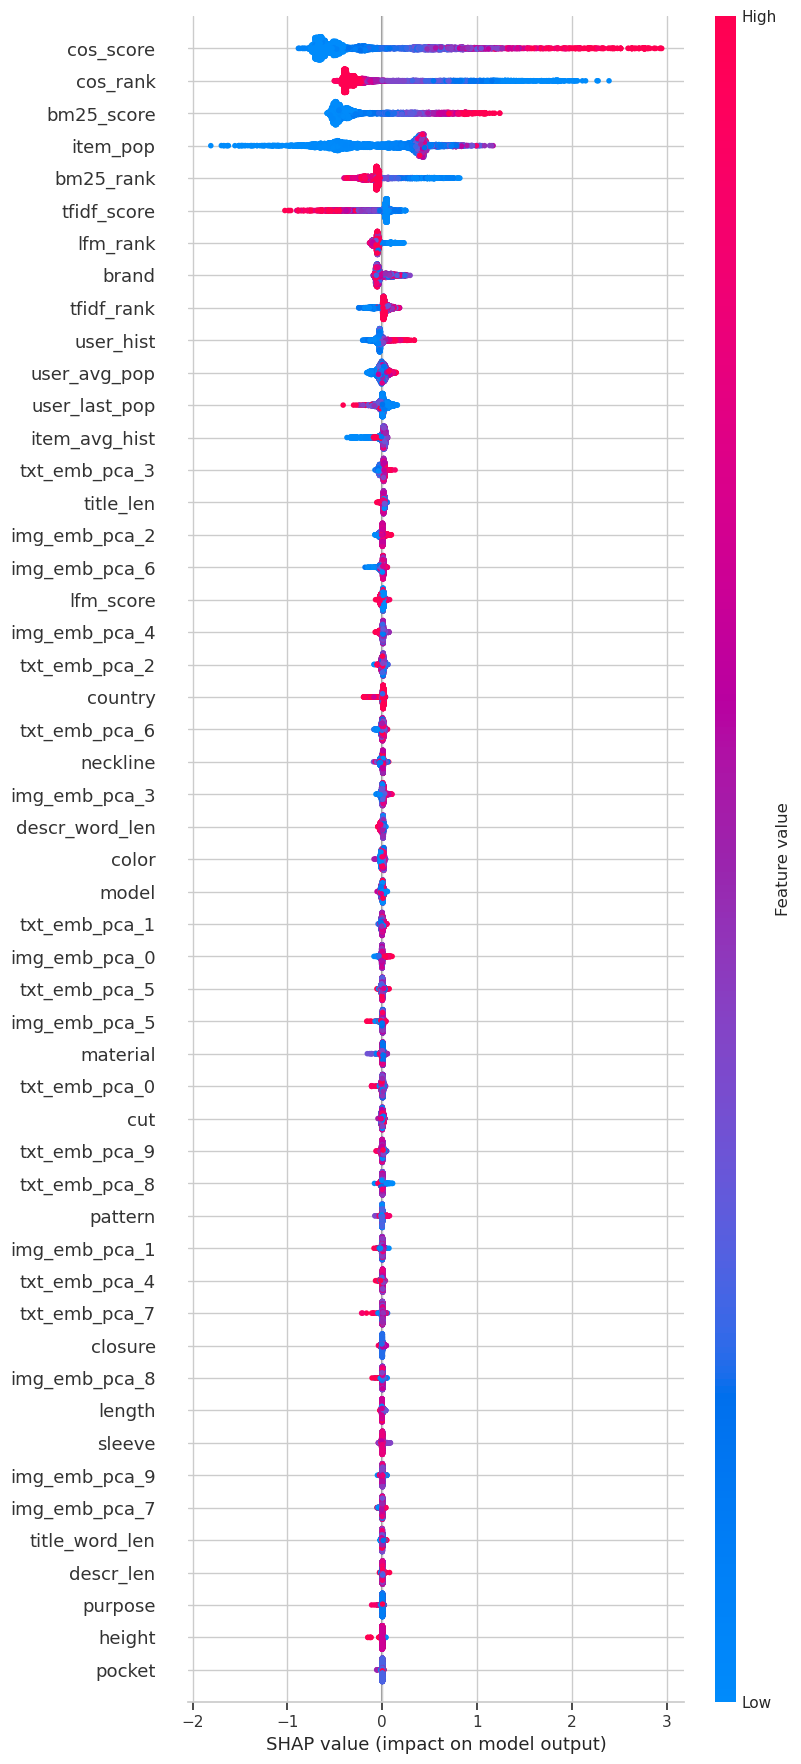

In [20]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(FEATURES))

### bar plot

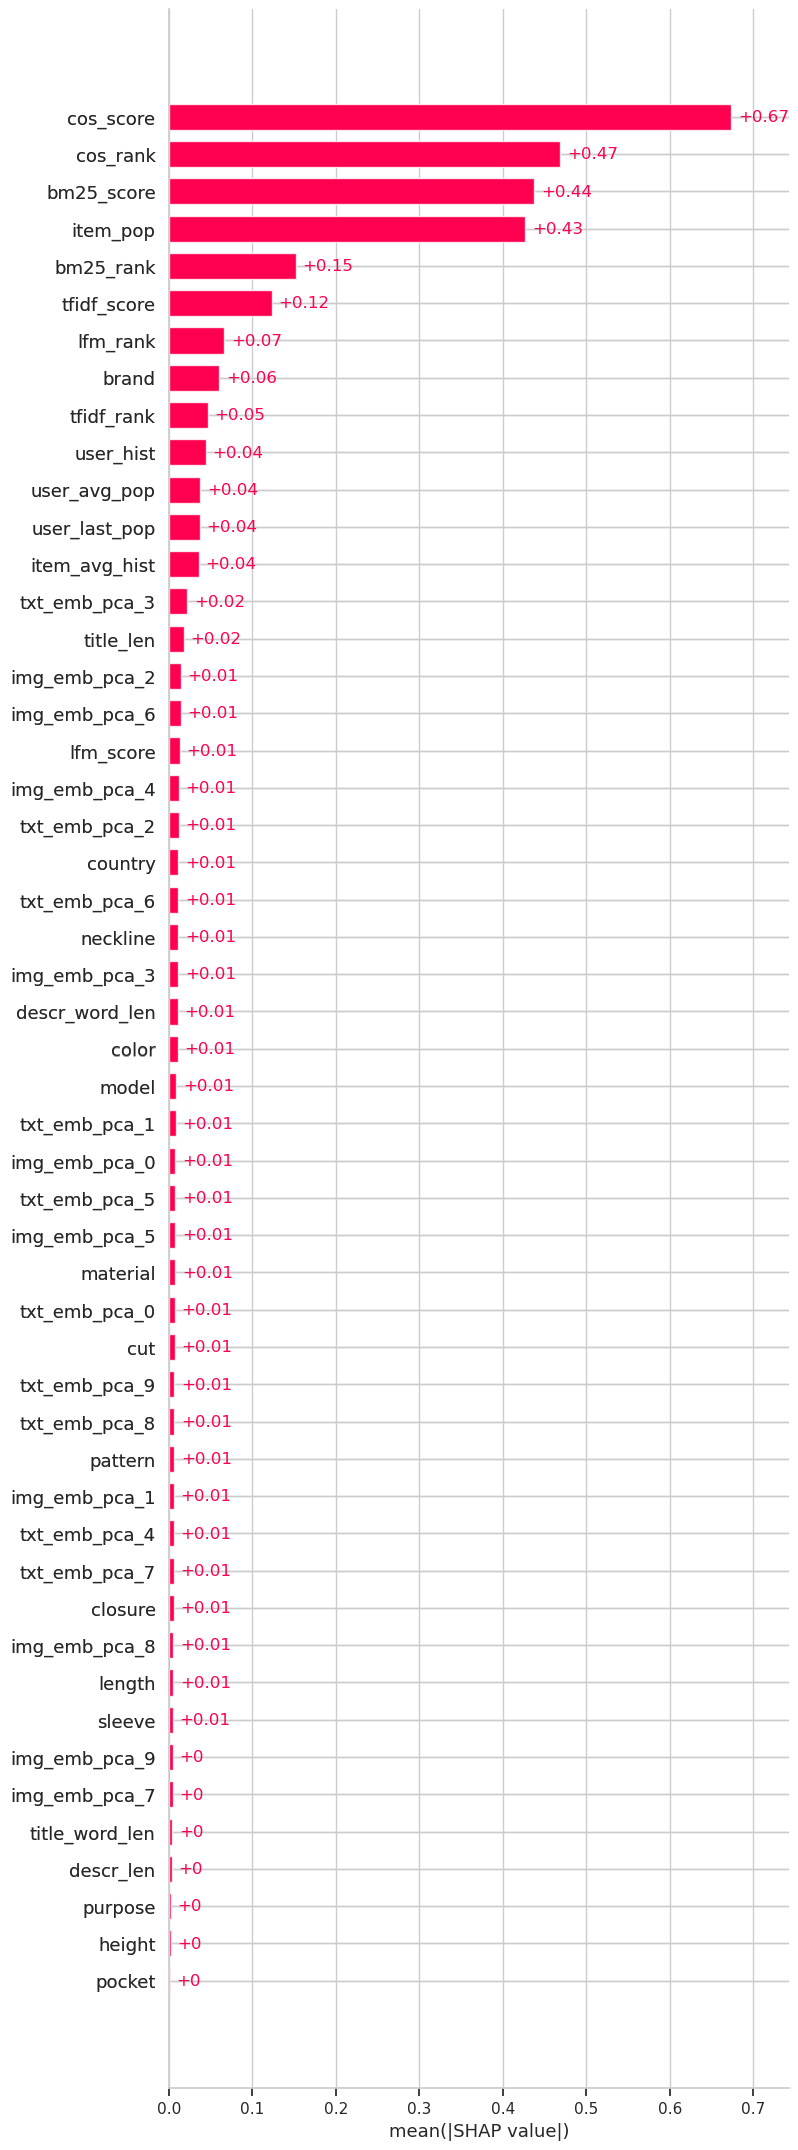

In [21]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(FEATURES))

# Выдаем рекомендации


In [5]:
# Загрузим listwise_model
cb_ranker_model = CatBoostRanker().load_model(models_path + "CB_ranker_model_best_4.cbm")

In [6]:
ranker_test = pl.scan_parquet(data_path + "ranker_test.parquet")

In [7]:
test_pool = Pool(
    data=ranker_test.select(FEATURES).collect().to_pandas(),
    group_id=get_catboost_group_id(ranker_test),
    cat_features=CATEGORIAL_FEATURES,
)

In [8]:
y_pred: np.ndarray = cb_ranker_model.predict(test_pool)

In [9]:
y_pred.shape

(5158647,)

In [10]:
ranker_test.select("user_id").unique().collect().shape

(167280, 1)

In [ ]:
ranker_test = add_score_and_rank(df=ranker_test, y_pred_scores=y_pred, name="listwise")
ranker_test.head(3)

In [12]:
# Dump listwise_model predictions for users
with open(candidates_data_path + "CB_ranker_predictions.dill", "wb") as f:
    dill.dump(ranker_test, f)

## Считаем метрики

In [13]:
predictions = (
    ranker_test.filter(pl.col("listwise_hybrid_rank") <= 15)
    .select(["user_id", "item_id"])
    .group_by("user_id")
    .agg(pl.col("item_id").alias("listwise_hybrid_rank_recs"))
)

In [15]:
test_df = (
    pl.scan_parquet(data_path + "test_df.parquet")
    .filter(pl.col("user_id").is_in(predictions.select("user_id").unique()))
    .collect()
    .join(
        other=predictions,
        how="left",
        on="user_id",
    )
)

In [16]:
for k in [3, 5, 10, 15]:
    print(
        f"""k = {k}: {RecommenderMetrics.evaluate_recommender(
            test_df, model_preds_col="listwise_hybrid_rank_recs", k=k
        )}\n"""
    )

k = 3: {'ndcg@k': 0.23549133136657016, 'recall@k': 0.14357347816481802, 'map@k': 0.1703623997024284}

k = 5: {'ndcg@k': 0.26638451825763204, 'recall@k': 0.16798554267934943, 'map@k': 0.1579600038524895}

k = 10: {'ndcg@k': 0.30467886591234333, 'recall@k': 0.20017603486420188, 'map@k': 0.1500357645260001}

k = 15: {'ndcg@k': 0.3238939576388759, 'recall@k': 0.21780143331174662, 'map@k': 0.1483019822567266}



# Выводы

Подбором параметров удалось улучшить метрики.

CatBoost показал себя хорошо на представленных данных. Относительно долгое обучение, но быстрый инференс (плюс использование gpu для вычислений)



|Stage|Description|Time (s)|Time (m)|
|---|---|---|---|
|**Data Preparation & Training**||||
|Collecting Train & Validation Pools|Preparing CatBoost Pools for training and validation|9.5|0.16|
|Ranker Training|Training the CatBoost Ranker model (750 iterations)|218|3.63|
|**Inference**||||
|Collecting Test Pool|Preparing the CatBoost Pool for testing|13|0.22|
|Inference|Generating predictions for 167K users|14.3|0.24|
|**Post-Processing**||||
|Add Rank & Score to Table|Adding rank and score predictions to main table|3.2|0.05|
|Combine Predictions|Combining predictions from different sources|0.3|0.01|
|**Total Time**|**Total time for all stages**|**258.3**|**4.30**|
